In [1]:
import random 
import numpy as np
import math
import matplotlib.pyplot as plt
import itertools
import math
import time  
from IPython.display import display, clear_output
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
import matplotlib.colors
from matplotlib.colors import ListedColormap

class Moss_Agent():

    def __init__(self,xmax=24,ymax=24,sex="M",shape="o",growth_rate=0.5):
        self.x = random.randint(0, xmax)
        self.y = random.randint(0, ymax)
        self.age = 0 
        self.age_limit = 5
        self.xmax = xmax
        self.ymax = ymax
        self.last_litter_time = 1
        self.shape = shape
        self.species="Moss"
        self.growth_rate=growth_rate
    
    def aging(self):
        self.age += 1

    def check_if_dead(self):
        if self.age > self.age_limit:
            return True
        else:
            return False

    def replicate(self, environ, env_list, env_xy):
        # Find all adjacent cells
        adjacent_cells = [(self.x-1, self.y), (self.x+1, self.y), (self.x, self.y-1), (self.x, self.y+1)]
        
        # Shuffle the list of adjacent cells randomly
        random.shuffle(adjacent_cells)

        # Iterate over shuffled list of adjacent cells
        for cell in adjacent_cells:
            x, y = cell

            # Check if cell is within bounds of environment
            if x >= 0 and x <= self.xmax and y >= 0 and y <= self.ymax:
                # Check if cell is empty
                if environ[x][y] == 4:
                    self.growth_rate = 0.9
                elif environ[x][y] == 3:
                    self.growth_rate = 0.3
                if (environ[x][y] == 1) or (environ[x][y] == 3) or (environ[x][y] == 4):
                    # Create new agent and add it to the environment and agent list
                    if (random.uniform(0, 1) <= self.growth_rate):
                        new_agent = Moss_Agent(self.xmax, self.ymax)
                        new_agent.x = x
                        new_agent.y = y
                        environ[x][y] = 0
                        self.last_litter_time = 0
                        ##############################
                        #code to delete previous occupants
                        if (x,y) in env_xy:
                            index = env_xy.index((x,y))
                            del env_xy[index]
                            del env_list[index]
                        ################################
                        return new_agent
        return None
 
class Weed_Agent(Moss_Agent):
    
    def __init__(self,xmax=24,ymax=24,sex="M",shape="o",growth_rate=0.6):
 
        # invoking the __init__ of the parent class
        Moss_Agent.__init__(self,xmax,ymax,sex,shape,growth_rate)
        self.species="Weed"
    
    def replicate(self, environ, env_list, env_xy):
        # Find all adjacent cells
        adjacent_cells = [(self.x-1, self.y), (self.x+1, self.y), (self.x, self.y-1), (self.x, self.y+1)]
        
        # Shuffle the list of adjacent cells randomly
        random.shuffle(adjacent_cells)

        # Iterate over shuffled list of adjacent cells
        for cell in adjacent_cells:
            x, y = cell

            # Check if cell is within bounds of environment
            if x >= 0 and x <= self.xmax and y >= 0 and y <= self.ymax:
                # Check if cell is empty
                if environ[x][y] == 0:
                    self.growth_rate = 0.65
                if (environ[x][y] == 1) or (environ[x][y] == 4) or (environ[x][y] == 0):
                    # Create new agent and add it to the environment and agent list
                    if (random.uniform(0, 1) <= self.growth_rate):
                        new_agent = Weed_Agent(self.xmax, self.ymax)
                        new_agent.x = x
                        new_agent.y = y
                        environ[x][y] = -1
                        self.last_litter_time = 0
                        ##############################
                        #code to delete previous occupants
                        if (x,y) in env_xy:
                            index = env_xy.index((x,y))
                            del env_xy[index]
                            del env_list[index]
                        ################################
                        return new_agent
        return None

class Environment():

    def __init__(self, tree_radius=2, n_trees=0, xsize=25, ysize=25):
        self.xsize = xsize
        self.ysize = ysize
        self.environ = np.ones((self.xsize,self.ysize))
        self.agent_list = []
    #######################################
        self.agent_xy = []
    #######################################
        self.n_trees = n_trees
        self.tree_radius = tree_radius
        self.place_trees()
    
    def place_trees(self):
        if self.n_trees > 0:
            for i in range(self.n_trees):
                x_cord = random.randint(0, self.xsize-1)
                y_cord = random.randint(0, self.ysize-1)
                self.environ[x_cord][y_cord] = 2

                # iterate over all cells within the circle's radius from the point
                for i in range(-self.tree_radius, self.tree_radius+1):
                    for j in range(-self.tree_radius, self.tree_radius+1):
                        if i**2 + j**2 <= self.tree_radius**2:
                            x = x_cord + i
                            y = y_cord + j
                            if x >= 0 and x < self.xsize and y >= 0 and y < self.ysize:
                                if i**2 + j**2 > (self.tree_radius-1)**2:
                                    self.environ[x][y] = 4
                                else:
                                    self.environ[x][y] = 2
        else:
            pass

    def add_agent(self,agent):
        self.agent_list.append(agent)
        ##########################################
        self.agent_xy.append((agent.x, agent.y))
        ##########################################
        if (agent.species == "Moss"):
            self.environ[agent.x, agent.y] = 0
        else:
            self.environ[agent.x, agent.y] = -1
        
    def simulate(self,tot_time, plotting = False):
        # Colors: https://matplotlib.org/stable/gallery/color/named_colors.html
        # -1: Weed
        # 0: Moss
        # 1: Normal land
        # 3: Tree
        # 4: Dry Land
        # 5: Fertile Land
        color_list = {-1: "lime", 0: "green", 1: "sienna",
                      2: "teal", 3: "black", 4: "peachpuff", 5: "darkturquoise"}
        cmap = ListedColormap([color_list[val] for val in sorted(color_list.keys())])
        times = 0
        
        
        weed_life = []
        moss_life = []
        
        for dt in range(tot_time):
            times = times+1
            clear_output(wait=True)
            plt.figure(figsize=(6, 6)) 
            plt.imshow(self.environ,cmap=cmap, label = {1:'ha'})
            ax = plt.gca() 
            for agent in self.agent_list:
                agent.aging()
                agent.last_litter_time +=1
                if agent.check_if_dead():
                    if agent.species == "Moss":
                        self.environ[agent.x, agent.y] = 4 
                    elif agent.species == "Weed":
                        self.environ[agent.x, agent.y] = 3
                elif agent.last_litter_time >= 3:
                    new_agent = agent.replicate(self.environ, self.agent_list, self.agent_xy)
                    
                    if new_agent:
                        self.add_agent(new_agent)
            plt.xlim(0,self.xsize)
            plt.ylim(0,self.ysize) 
            plt.title('Time:%s'%times, loc = 'center')
            plt.show()
            time.sleep(0.1)
            #print(len(self.agent_list))  #to see if agents are deleting right
            
            
            ###########################################################
            #plot simulate stuff
            weed_count = 0
            moss_count = 0
            for i in self.environ:
                for j in i:
                    if j == -1:
                        weed_count+=1
                    elif j == 0:
                        moss_count+=1
            weed_life.append(weed_count)
            moss_life.append(moss_count)
        if plotting == True:
            plt.plot(moss_life,c='red',label="Moss")
            plt.plot(weed_life,c='blue',label="Weed")
            plt.xlabel('Time')
            plt.ylabel('Cell Count')
            plt.title('Moss vs Weeds')
            plt.legend()
            plt.show()



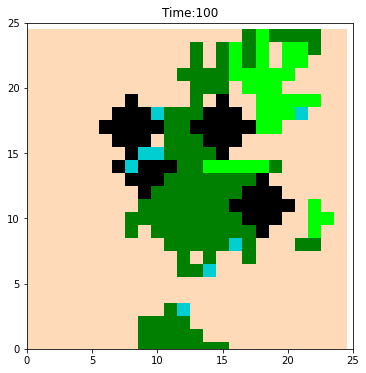

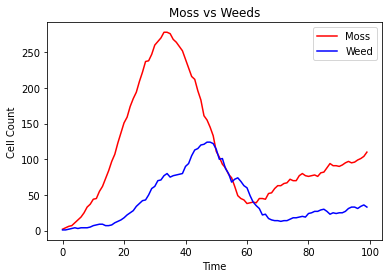

In [13]:
env = Environment(n_trees=5, tree_radius=3)
moss1 = Moss_Agent()
weed1 = Weed_Agent()
env.add_agent(weed1)
env.add_agent(moss1)
moss2 = Moss_Agent()
env.add_agent(moss2)
env.simulate(100, plotting = True)